<a href="https://colab.research.google.com/github/gabrielmelo00/Machine-Learning-Projects/blob/main/Non_Negative_Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMF Practical Work

**Roland Badeau - Notebook code by Umut Simsekli** 

Telecom Paris - TSIA 206

Students:


*  Gabriel Silva Vieira de Melo
*  Gabriela Barbosa Guedes Pereira 



#**Question 1:**

Using the $\beta$-divergence we can write the following cost function that we want to minimize to solve this optimization problem.

$$ C_{\beta} = \sum_{i,j}d_{\beta}(x_{ij}||\hat{x}_{ij}) = \sum_{i,j}\frac{x_{ij}^{\beta}}{\beta(\beta-1)} - \frac{x_{ij}\hat{x}_{ij}^{\beta-1}}{\beta-1} + \frac{\hat{x}_{ij}^{\beta}}{\beta}$$, where $\hat{x}_{ij} = \sum_{k}w_{ik}h_{kj}$ 

Since we want ot minimize it with respect to W and H, we compute the gradient as follow:

$$\frac{\partial C_{\beta}}{\partial w_{ik}} = \sum_{j}-\frac{x_{ij}(\beta - 1)(\hat{x}_{ij})^{\beta-2}h_{kj}}{\beta-1} + \frac{\beta(\hat{x}_{ij})^{\beta - 1}h_{kj}}{\beta}$$

$$\frac{\partial C_{\beta}}{\partial h_{kj}} = \sum_{i}-\frac{x_{ij}(\beta - 1)(\hat{x}_{ij})^{\beta-2}w_{ik}}{\beta-1} + \frac{\beta(\hat{x}_{ij})^{\beta - 1}w_{ik}}{\beta}$$

Now, we set these adaptative stepsizes as:

$$ \eta_{w} = \frac{w_{ik}}{\sum_{j}\hat{x}_{ij}^{\beta-1}h_{kj}}$$

$$ \eta_{h} = \frac{h_{kj}}{\sum_{i}\hat{x}_{ij}^{\beta-1}w_{ik}}$$

Finally we can aply this to the following update rule $x \leftarrow x + \eta_x\frac{\partial C_{\beta}}{\partial x}$ and, by using the respective gradient and stepsize, we get:

$$W \leftarrow W \circ \frac{(X \circ \hat{X}^{\beta-2})H^T}{\hat{X}^{\beta-1}H^{T}}$$


$$H \leftarrow H \circ \frac{W^T(X \circ \hat{X}^{\beta-2})}{W^T\hat{X}^{\beta-1}}$$

#**Question 2:**

In [ ]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


<Figure size 432x288 with 0 Axes>

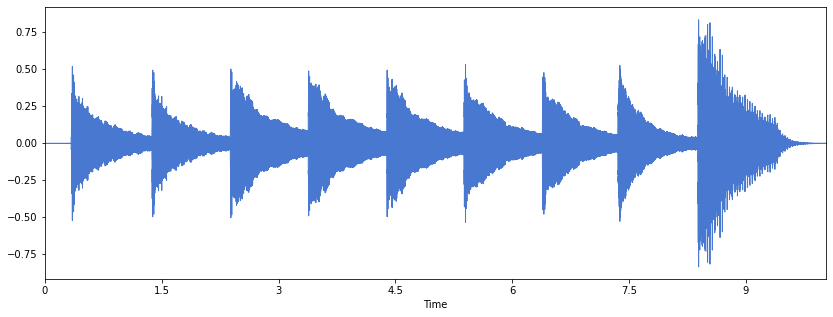

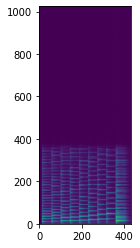

In [ ]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [ ]:
# Implement MUR for NMF with beta-divergence 
def d_beta(X,X_hat,beta):
  I = X.shape[0]
  J = X.shape[1]
  d_beta = 0
  for i in range(I):
      for j in range(J):
          d_beta += (1/((beta)*(beta-1)))*(X[i,j]**beta + (beta-1)*X_hat[i,j]**beta - beta*X[i,j]*X_hat[i,j]**(beta-1))
  return d_beta



def nmfMUR(X, beta, k, epsilon=0.005):
  #getting the dimensions of the Matrix W and H
  I = X.shape[0]
  J = X.shape[1]
  #creating the matrix W, H and initializing them randomly
  W = np.random.rand(I,k)
  H = np.random.rand(k,J)
  #creating X_hat = WH
  X_hat = np.matmul(W,H)
  #initializing cost to use in the stop criteria 
  cost = [1.1*d_beta(X,X_hat,beta),d_beta(X,X_hat,beta)]
  #loop with the stop criteria
  while np.abs((cost[-1]-cost[-2])/cost[-2])>epsilon:
      W = W * (((X * np.power((W.dot(H) + 10e-10),beta-2)).dot(H.transpose())) / ((np.power((W.dot(H) + 10e-10),beta-1)).dot(H.transpose())))
      H = H * (((W.transpose()).dot((X * np.power((W.dot(H) + 10e-10),beta-2)))) / (((W.transpose()).dot(np.power((W.dot(H)) + 10e-10,beta-1)))))
      V_hat = np.matmul(W,H)
      cost.append(d_beta(X,V_hat,beta))
  return W,H

We constructed this algorithm by using this stop criteria:

$$|D_{n + 1} - D_n| < \epsilon|D_n|$$

,where $D_n = d_{\beta}(X||\hat{X})$ at iteration n

We used the following article to understand better the stop criteria:

F. G. Germain and G. J. Mysore, "Stopping Criteria for Non-Negative Matrix Factorization Based Supervised and Semi-Supervised Source Separation," in IEEE Signal Processing Letters, vol. 21, no. 10, pp. 1284-1288, Oct. 2014, doi: 10.1109/LSP.2014.2331981. [Link](https://ieeexplore.ieee.org/abstract/document/6840338)


In [ ]:
# k = 8, eight notes, and Beta = 2, euclidean distance 
W, H = nmfMUR(X,2,8)

In [ ]:
# Use Wiener filtering to reconstruct each note separately
def reconstructNote(X, W, H, note):
  return X*np.divide(np.matmul(W[:,note].reshape(-1,1),H[note,:].reshape(1,-1)),np.matmul(W,H)+10e-10)

# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


In [ ]:
#Separately note
La = reconstructNote(Xstft, W, H, 0)

In [ ]:
#Separately note
Sol = reconstructNote(Xstft, W, H, 1)

In [ ]:
#Separately note
Fa = reconstructNote(Xstft, W, H, 2)

In [ ]:
#Separately note
Si = reconstructNote(Xstft, W, H, 3)

In [ ]:
#Separately note
Mi = reconstructNote(Xstft, W, H, 4)

In [ ]:
#Separately note
Do_8 = reconstructNote(Xstft, W, H, 5)

In [ ]:
#Separately note
Do = reconstructNote(Xstft, W, H, 6)

In [ ]:
#Separately note
Re = reconstructNote(Xstft, W, H, 7)

In [ ]:
#Reconstructing all the C major scale
CMajorScale = Do + Re + Mi + Fa + Sol + La + Si + Do_8

So, we are playing each note of the C major scale

In [ ]:
y_hat = librosa.istft(Do)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(Re)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(Mi)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(Fa)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(Sol)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(La)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(Si)
ipd.Audio(y_hat, rate=sr)

In [ ]:
y_hat = librosa.istft(Do_8)
ipd.Audio(y_hat, rate=sr)

Now, we are playing the reconstructed version of the C major scale. This part was made by summing each separated note produced by the non-negative matrix factorization.

In [ ]:
y_hat = librosa.istft(CMajorScale)
ipd.Audio(y_hat, rate=sr)

#**Question 3:**

In [ ]:
W1, H1 = nmfMUR(X,1.5,8)
W2, H2 = nmfMUR(X,1.8,8)

In [ ]:
#Do produced with Beta = 2.0
y_hat = librosa.istft(Do)
ipd.Audio(y_hat, rate=sr)

In [ ]:
#Do produced with Beta = 1.5
Do_beta_1 = reconstructNote(Xstft, W1, H1, 3)
y_hat = librosa.istft(Do_beta_1)
ipd.Audio(y_hat, rate=sr)

In [ ]:
#Do produced with Beta = 1.8
Do_beta_2 = reconstructNote(Xstft, W2, H2, 1)
y_hat = librosa.istft(Do_beta_2)
ipd.Audio(y_hat, rate=sr)

By changing $\beta$ in the divergence, we can say that there's no such a big difference in the audio produced. When we listen to all Do notes, we cannot notice any notable difference. So, $\beta$ has no great impact in the final result.

In [ ]:
W3, H3 = nmfMUR(X,2,6)

In [ ]:
#Note reconstructed using k = 6 in the NMF
Note = reconstructNote(Xstft, W3, H3, 1)
y_hat = librosa.istft(Note)
ipd.Audio(y_hat, rate=sr)

When we use a different number of K, number of columns of matrix in W, we cannot reconstruct a separetly note. When we listen to this reconstructed audio produced by the NMF with $k=6$, we can notice that there's more than one musical note in the audio, we have Do and Si in the middle of the audio. That was expected since we are decomposing with a number of columns different from 8, because the audio of the C major scale has 8 different notes.